In [1]:
# Elementos de matriz y funciones personalizadas
from elementos_matriz import *
import matplotlib.pyplot as plt

# Energía de la molécula de hidrógeno $\mathrm{H}_2$
---

## Elementos de matriz

Dado que el cálculo de las energías $E_1^\text{RHF}$, $E_2^\text{RHF}$ y $E_1^\text{UHF}$ dependen de los mismos elementos de matriz, se calcularán todos los elementos de matriz para un rango de distancias interatómicas y posteriormente estos serán consultados para la determinación de la energía.

In [2]:
# Energía del átomo de hidrógeno en la base STO-3G
RB = np.array([1000000, 0, 0])
EH_STO3G = fpp(1, d, a, RA, RB, ZA, ZB)

In [3]:
# calcular elementos de matriz h11, h22, J11, J22, J12, K12 y hnuc

h11, h22, J11, J22, J12, K12, hnuc = [], [], [], [], [], [], []

distances = np.arange(0.15,10.06,0.1) # distancias internucleares
for x in distances:
    RB = np.array([x, 0, 0]) # posición del núcleo B
    val1, val2, val3, val4, val5, val6 = elementos_matriz(d, a, RA, RB, ZA, ZB)
    val7 = 1/(np.linalg.norm(RA-RB)) # repulsión nuclear
    h11.append(val1)
    h22.append(val2)
    J11.append(val3)
    J22.append(val4)
    J12.append(val5)
    K12.append(val6)
    hnuc.append(val7)

# convertir listas en arreglos de numpy
h11 = np.array(h11)
h22 = np.array(h22)
J11 = np.array(J11)
J22 = np.array(J22)
J12 = np.array(J12)
K12 = np.array(K12)

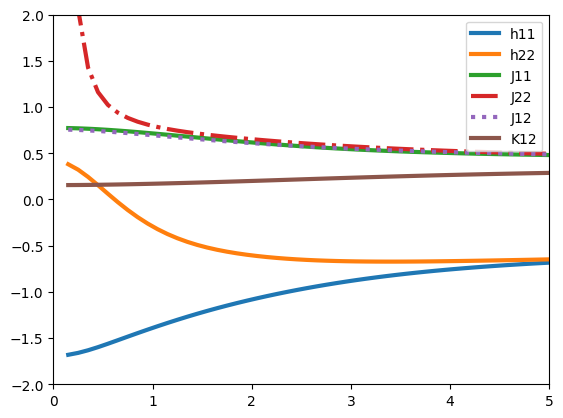

In [4]:
plt.plot(distances, h11, linewidth=3, label='h11')
plt.plot(distances, h22, linewidth=3, label='h22')
plt.plot(distances, J11, linewidth=3, linestyle='solid', label='J11')
plt.plot(distances, J22, linewidth=3, linestyle='dashdot', label='J22')
plt.plot(distances, J12, linewidth=3, linestyle='dotted', label='J12')
plt.plot(distances, K12, linewidth=3, label='K12')

plt.xlim(0,5)
plt.ylim(-2,2)

plt.legend()
plt.show()

## Hartree-Fock Restringido (RHF)

$E_1^\text{RHF} = 2h_{11} + J_{11} + h_\text{nuc}$

$E_2^\text{RHF} = 2h_{22} + J_{22} + h_\text{nuc}$

In [5]:
RHF1 = 2*h11 + J11 + hnuc # energía restringida (orbital ligante)
RHF2 = 2*h22 + J22 + hnuc # energía restringida (orbital antiligante)

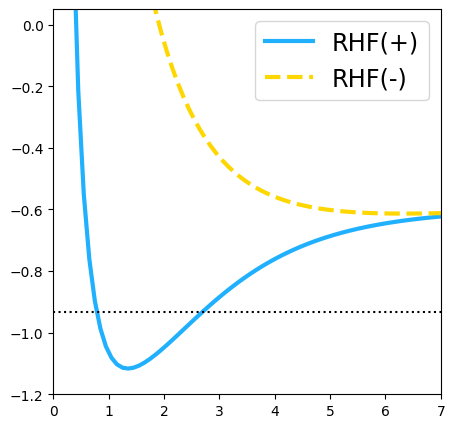

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))  # 1 fila, 1 columnas, tamaño de figura (15, 5)

ax.plot(distances, RHF1, label='RHF(+)', linestyle='solid', linewidth=3, color='#21b0fe') # energías RHF orbital ligante
ax.plot(distances[3:], RHF2[3:], label='RHF(-)', linestyle='dashed', linewidth=3, color='#fed700') # energías RHF orbital antiligante

ax.axhline(y = 2*EH_STO3G, color='black', linestyle='dotted') # energía base 2 átomos de hidrógeno (STO-3G)

xmin, xmax = 0, 7
ax.set_xlim(xmin, xmax)
ymin, ymax = -1.2, 0.05
ax.set_ylim(ymin, ymax)
ax.legend(fontsize='xx-large')

plt.show()

---
## Hartree-Fock sin restricción (UHF)

$$\eta_1 = \cos2\theta =  \frac{E_2^\text{RHF} - E_1^\text{RHF}}{J_{11} + J_{22} - 2J_{12} + 4K_{12}}$$

$$\eta_2 = \cos2\theta =  \frac{E_1^\text{RHF} - E_2^\text{RHF}}{J_{11} + J_{22} - 2J_{12} + 4K_{12}} = -\eta_1$$

In [7]:
def E_UHF(orbital:str, i:int):
    """ Cálculo de la energía no restringida (UHF)
    
    Parámetros:
        orbital: ligante o antiligante (en t=0)
        i: índice de la lista
    """

    eta1 = (RHF2[i] - RHF1[i]) / (J11[i] + J22[i] - 2*J12[i] + 4*K12[i]) # eta del caso ligante
    if orbital == 'ligante': # caso ligante
        eta = eta1
        theta = 0 if (eta > 1) or (eta < 0) else np.arccos(eta)/2
    else: # caso antiligante
        eta = -eta1
        theta = 0 if (eta > 1) or (eta < 0) else np.arccos(eta)/2
    
    cos = np.cos(theta)
    sin = np.sin(theta)

    if orbital == 'ligante':
        E1 = 2*h11[i]*np.power(cos,2) + 2*h22[i]*np.power(sin,2)
        E2 = J11[i]*np.power(cos,4) + J22[i]*np.power(sin,4) 
    else:
        E1 = 2*h11[i]*np.power(sin,2) + 2*h22[i]*np.power(cos,2)
        E2 = J11[i]*np.power(sin,4) + J22[i]*np.power(cos,4)

    E3 = (2*J12[i]-4*K12[i])*np.power(cos,2)*np.power(sin,2)
    Etot = E1 + E2 + E3 + hnuc[i] # energía total
    
    return  Etot, theta, eta

In [8]:
ang1, eta1 = [], [] # lista de ángulos para cada distancia internuclear
ang2, eta2 = [], [] # lista de ángulos para cada distancia internuclear

UHF1 = [] # energías UHF, orbital ligante en t=0
UHF2 = [] # energías UHF, orbital antiligante en t=0
for i in range(len(distances)):
    # caso orbital lignante en t=0
    energia1, theta1, eta = E_UHF('ligante', i)
    UHF1.append(energia1)
    ang1.append(theta1)
    eta1.append(eta)
    # caso orbital antiligante en t=0
    energia2, theta2, eta = E_UHF('antiligante', i)
    UHF2.append(energia2)
    ang2.append(theta2)
    eta2.append(eta)

In [9]:
# índice del primer ángulo diferente de cero/NaN, RHF
index = next((i for i, x in enumerate(ang1) if x), None)
x0, y0 = distances[index], UHF1[index]
x_ang, y_ang = distances[index], ang1[index]

# índice del primer ángulo diferente de cero/NaN, UHF
index2 = next((i for i, x in enumerate(ang1) if x), np.nan)
xUHF, yUHF = distances[index2], UHF1[index2]
xUHG_ang, yUHG = distances[index2], ang1[index2]

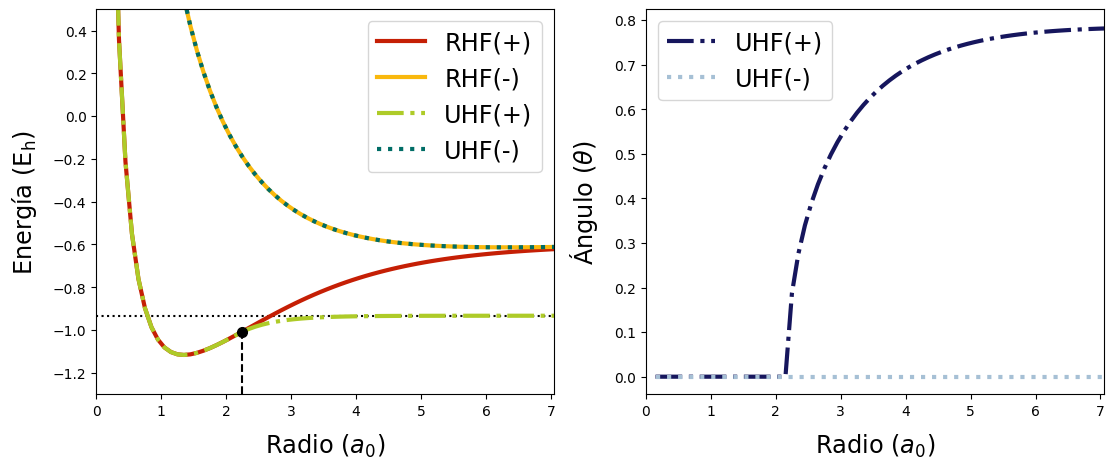

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))  # 1 fila, 1 columnas, tamaño de figura (15, 5)

###################
### Gráfica derecha
###################
axs[0].axhline(y = 2*EH_STO3G, color='black', linestyle='dotted') # energía base 2 átomos de hidrógeno (STO-3G)

axs[0].plot(distances, RHF1, label='RHF(+)', linestyle='solid', linewidth=3, color='#c51f05') # energías RHF orbital ligante
axs[0].plot(distances[3:], RHF2[3:], label='RHF(-)', linestyle='solid', linewidth=3, color='#f9b80d') # energías RHF orbital antiligante
axs[0].plot(distances, UHF1, label='UHF(+)', linestyle='dashdot', linewidth=3, color='#aecb28') # energías UHF
axs[0].plot(distances, UHF2, label='UHF(-)', linestyle='dotted', linewidth=3, color='#006d66') # energías UHF

ymin, ymax = -1.3, 0.5
axs[0].vlines(x=x0, ymin=ymin, ymax=y0, color='black', linestyle='dashed')
axs[0].plot(x0, y0, ls="", marker="o", color='black', markersize=7) # punto a partir de donde RHF y UHF ya no son iguales

xmin, xmax = 0, 7.05
axs[0].set_xlim(xmin, xmax)
axs[0].set_ylim(ymin, ymax)
axs[0].legend(fontsize='xx-large')
axs[0].set_xlabel('Radio ($a_0$)', fontsize='xx-large', labelpad=10)
axs[0].set_ylabel(r'Energía ($\text{E}_\text{h}$)', fontsize='xx-large', labelpad=10)

#####################
### Gráfica izquierda
#####################
axs[1].plot(distances, ang1, label='UHF(+)', linestyle='dashdot', linewidth=3, color='#16165d') # energías UHF
axs[1].plot(distances, ang2, label='UHF(-)', linestyle='dotted', linewidth=3, color='#a6c0d5') # energías UHF

xmin, xmax = 0, 7.05
axs[1].set_xlim(xmin, xmax)
axs[1].legend(fontsize='xx-large')
axs[1].set_xlabel('Radio ($a_0$)', fontsize='xx-large', labelpad=10)
axs[1].set_ylabel(r'Ángulo ($\theta$)', fontsize='xx-large', labelpad=10)

plt.show()

## Interacción de configuraciones CI

Los eigenvalores resultantes de diagonalizar la matriz $\mathbf{H}$ es
$$ E_{\pm} = \frac{H_{11} + H_{22} \pm \sqrt{(H_{11} - H_{22})^2 + 4|H_{12}|^2}}{2} $$

donde se tienen los cuatro casos de

$$ c_0^\pm \equiv \frac{H_{12}}{\sqrt{| E_{\pm} - H_{11}|^2 + |H_{12}|^2}} $$

$$ c_1^\pm \equiv \frac{E_{\pm} - H_{11}}{\sqrt{|E_{\pm} - H_{11}|^2 + |H_{12}|^2}} $$

donde

$$ H_{11} = 2h_{11} + J_{11} + \frac{1}{R} = E_1^\text{RHF}$$
$$ H_{22} = 2h_{22} + J_{22} + \frac{1}{R} = E_2^\text{RHF}$$
$$ H_{12} = J_{12} + \frac{1}{R} $$

In [11]:
# elementos de la matriz de configuración
H11 = RHF1
H22 = RHF2
H12 = J12 + hnuc

# energías asociadas a la diagonalización
disc = np.square(H11-H22) + 4*np.square(H12)
EP = (H11 + H22 + np.sqrt(disc))/ 2 # E_11, mayor energía
EM = (H11 + H22 - np.sqrt(disc))/ 2 # E_22, menor energía (caso base)

In [12]:
# Cálculo de coeficientes c0^\pm y c1^\pm

# coefs. asociados a E_11
denP = np.sqrt(np.square(EP - H11) + np.square(H12))
c0P = H12 / denP
c1P = (EP - H11) / denP

# coefs. asociados a E_22
denM = np.sqrt(np.square(EM - H11) + np.square(H12))
c0M = H12 / denM
c1M = (EM - H11) / denM

Los coeficientes deben de cumplir la condición de normalización
$$ |c_0^\pm|^2 + |c_1^\pm|^2 = 1 $$

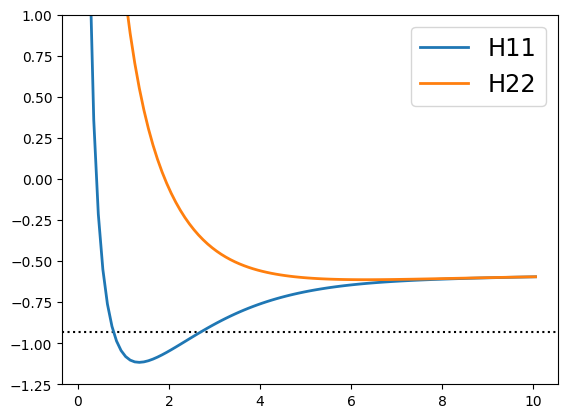

In [20]:
plt.axhline(2*EH_STO3G, color='black', linestyle='dotted') # energía base 2 átomos de hidrógeno (STO-3G)

plt.plot(distances, H11, linewidth=2, label='H11')
plt.plot(distances, H22, linewidth=2, label='H22')

# plt.xlim(0,7)
plt.ylim(-1.25,1)

plt.legend(fontsize='xx-large')
plt.show()

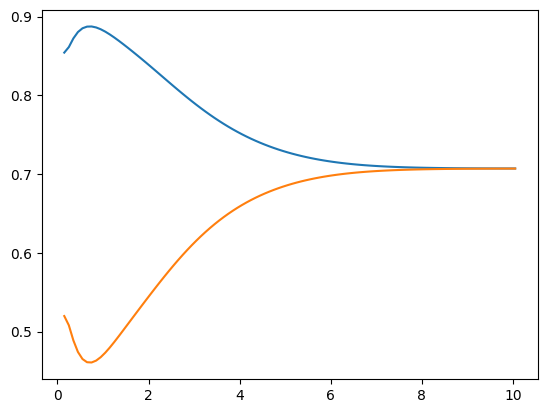

In [14]:
plt.plot(distances, c0M)
plt.plot(distances, -c1M)

plt.show()

## Apéndice

In [17]:
def guardar(nombre:str, data:list):
    """ Guardar lista de datos

    nombre: nombre del archivo
    data: lista de datos por ser guardada
    """
    with open(f"data/H2_{nombre}.csv", "w") as file:
        file.write(f"{nombre}\n")
        for item in data:
            file.write(f"{item}\n")

In [18]:
guardar('Distancias', distances)

guardar('h11', h11)
guardar('h22', h22)
guardar('J11', J11)
guardar('J22', J22)
guardar('J12', J12)
guardar('K12', K12)

guardar('RHF1', RHF1)
guardar('RHF2', RHF2)
guardar('UHF1', UHF1)
guardar('UHF2', UHF2)